<a href="https://colab.research.google.com/github/akfrdma0125/EfficientFrontier/blob/main/Efficient_Frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 import


In [ ]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 9.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
from pykrx import stock
from datetime import datetime
from platform import python_version
print(python_version())
print(pd.__version__)

3.10.11
1.5.3


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
import cvxopt as opt
from cvxopt import solvers

In [ ]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    rwset = np.random.random(9)
    rwset = np.array(rwset/np.sum(rwset))
 
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rwset)
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma, w


In [ ]:
def minimum_port_weight(returns):
  mean_ret = np.mean(returns,axis=1)
  cov_ret = np.cov(returns)
  n = mean_ret.shape[0]
  one_array = np.ones(n)
 
  #List of target portfolio returns (목표 포트폴리오 수익률 리스트)
  mus = list(np.arange(0,0.0008,0.00005))
    
  # Convert to cvxopt matrices (cvxopt matrix로 변환)
  Q = opt.matrix(cov_ret)
  p = opt.matrix(0.0, (n, 1))
    
  # Create constraint matrices (최적화 문제 제약조건 설정)
  A = opt.matrix(np.stack((mean_ret,one_array)))
  weights_list = []
  mean_std_list = []
  for mu in mus:
    b = opt.matrix(np.array([mu,1]))
    weights = solvers.qp(Q, p, A = A, b = b)['x']
    weight_array = np.array(list(weights))
    port_ret = np.matrix(weight_array).dot(np.matrix(mean_ret).T)
    port_std = np.sqrt(np.matrix(weight_array).dot(np.matrix(cov_ret)).dot(np.matrix(weight_array).T))
    
    weights_list.append(list(weights))
    mean_std_list.append([port_ret[0,0],port_std[0,0]])
  
  return weights_list,mean_std_list


In [ ]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

# 기본 자료 설정

In [ ]:
tickers = stock.get_market_ticker_list();
stock_list=['삼성전자', 'SK하이닉스', 'NAVER', 'LG화학', '카카오','삼성SDI', '현대차', '기아', '셀트리온', 'POSCO']

start_time = '20180101'
end_time = '20190430'

stock_df = pd.DataFrame()

In [ ]:
for i in tickers:
    name = stock.get_market_ticker_name(i)
    if name in stock_list:
        stock_df[name] = stock.get_market_ohlcv(start_time, end_time, i, "d")['종가']

In [ ]:
ptc_ret = stock_df.pct_change(1).dropna()
ptc_ret

,LG화학,NAVER,SK하이닉스,기아,삼성SDI,삼성전자,셀트리온,카카오,현대차
날짜,,,,,,,,,
2018-01-03,-0.003650,-0.015819,0.014360,-0.006098,-0.021226,0.011760,0.092073,0.017065,0.006689
2018-01-04,-0.034188,0.025263,-0.007722,-0.032209,0.004819,-0.010461,0.013379,0.046980,-0.026578
2018-01-05,0.024020,0.016796,0.028534,0.012678,0.057554,0.020360,0.067597,0.000000,0.017065
2018-01-08,0.048148,0.046256,-0.013871,0.014085,0.022676,-0.001919,0.133382,0.022436,0.013423
2018-01-09,0.002356,-0.006317,-0.016624,0.003086,-0.026608,-0.031142,-0.033057,-0.015674,0.009934
...,...,...,...,...,...,...,...,...,...
2019-04-24,-0.025606,0.004149,-0.030864,0.017381,-0.006522,-0.009956,-0.015801,0.012876,0.018382
2019-04-25,0.009682,-0.004132,0.021656,-0.033030,0.006565,-0.002235,-0.029817,-0.016949,-0.003610
2019-04-26,-0.017808,-0.020747,-0.019950,0.011779,-0.004348,0.004479,0.002364,-0.008621,-0.018116


In [ ]:
ret_matrix = ptc_ret.values.T

In [ ]:
ret_matrix

array([[-0.00364964, -0.03418803,  0.02402023, ..., -0.01780822,
         0.0181311 , -0.0109589 ],
       [-0.01581937,  0.02526269,  0.01679582, ..., -0.02074689,
         0.01694915, -0.00416667],
       [ 0.01436031, -0.00772201,  0.02853437, ..., -0.01995012,
         0.0178117 , -0.0125    ],
       ...,
       [ 0.0920732 ,  0.01337947,  0.06759732, ...,  0.00236407,
         0.01886792, -0.01851852],
       [ 0.01706485,  0.04697987,  0.        , ..., -0.00862069,
         0.03913043,  0.0041841 ],
       [ 0.00668896, -0.02657807,  0.01706485, ..., -0.01811594,
         0.02583026, -0.00359712]])

In [ ]:
SReverse = np.linalg.inv(S)
SReverse

array([[12.60788461, -0.27832904,  0.95385734,  0.70700555, -4.79805246,
        -2.33542186, -0.23096714, -1.48160338, -1.56296993],
       [-0.27832904, 12.76394369,  1.02389691,  0.03461455, -0.10772255,
        -2.84480035, -0.08542543, -3.65036574, -1.03820413],
       [ 0.95385734,  1.02389691, 12.5316383 , -0.04568419, -2.24542962,
        -9.67789366, -0.51504721, -1.029456  ,  0.33294899],
       [ 0.70700555,  0.03461455, -0.04568419, 17.82764508, -1.06695423,
         0.76029327, -0.41200417, -1.11345719, -9.85380462],
       [-4.79805246, -0.10772255, -2.24542962, -1.06695423, 10.11672338,
        -1.43177443, -0.96981964,  0.37492769,  0.94290736],
       [-2.33542186, -2.84480035, -9.67789366,  0.76029327, -1.43177443,
        24.16957812,  1.01764804, -0.91064268, -0.77428422],
       [-0.23096714, -0.08542543, -0.51504721, -0.41200417, -0.96981964,
         1.01764804,  3.72573484, -0.80065523,  0.20636296],
       [-1.48160338, -3.65036574, -1.029456  , -1.11345719,  0

In [ ]:
Z= SReverse@ptc_ret.mean()
Z

array([-0.00292275, -0.01088699,  0.00386395,  0.0204165 ,  0.00500621,
       -0.00399632,  0.00064596, -0.00126344, -0.00985488])

In [ ]:
sum = Z.sum()
for i in Z:
  print(i/sum)

-2.898909217963965
-10.798175211233714
3.8324237038264477
20.249939167742873
4.965366498026158
-3.9637196062080893
0.6406905871504087
-1.253134202761214
-9.774481718578905


In [ ]:
n_assets = 9
n_ports = 500

In [ ]:
output = []
for i in range(0,1000):
  port_mean, port_std, weights = random_portfolio(ret_matrix)
  mean_std_array = np.array([port_mean, port_std])
  weights_array = np.array(weights)
  merged_array = np.concatenate((mean_std_array,weights_array),axis=None)
  merged_list = merged_array.tolist()
  output.append(merged_list)
 
col_list = list(ptc_ret.columns)
col_list = [i + '_W' for i in col_list]
 
df_col = ['Port_ret','Port_std'] + col_list
port_ret_var = pd.DataFrame(output,columns = df_col) 

In [ ]:
port_ret_var

,Port_ret,Port_std,LG화학_W,NAVER_W,SK하이닉스_W,기아_W,삼성SDI_W,삼성전자_W,셀트리온_W,카카오_W,현대차_W
0,0.000121,0.012117,0.082201,0.053846,0.062425,0.130699,0.087892,0.199616,0.136003,0.162513,0.084805
1,0.000163,0.013631,0.112128,0.011851,0.018192,0.124273,0.015538,0.055190,0.230995,0.123394,0.308439
2,0.000085,0.011704,0.012713,0.138718,0.101525,0.122841,0.135695,0.132869,0.088977,0.119954,0.146709
3,0.000127,0.012357,0.225378,0.007271,0.137722,0.108144,0.001266,0.169523,0.143356,0.079263,0.128076
4,0.000286,0.013425,0.084168,0.024094,0.020737,0.188397,0.232366,0.037440,0.113300,0.249372,0.050125
...,...,...,...,...,...,...,...,...,...,...,...
995,0.000185,0.011771,0.136613,0.107819,0.183644,0.180774,0.101357,0.139738,0.037541,0.018187,0.094327
996,-0.000122,0.011515,0.190355,0.197308,0.063296,0.076126,0.045119,0.072919,0.057283,0.067317,0.230278
997,-0.000144,0.011994,0.121873,0.260650,0.132377,0.032287,0.085637,0.037329,0.102275,0.071141,0.156432
998,-0.000085,0.012662,0.111592,0.147368,0.132774,0.010558,0.175672,0.130666,0.011685,0.166519,0.113166


In [ ]:
weights,mean_stds = minimum_port_weight(ret_matrix)
#To dataframe (데이타 프레임으로 변경)
col_name = ptc_ret.columns + '_Weight'
weights_df = pd.DataFrame(weights,columns=col_name)
mean_stds_df = pd.DataFrame(mean_stds,columns=['Port_ret','Port_std'])

In [ ]:
mean_stds_df.head()

,Port_ret,Port_std
0,9.656176e-20,0.010941
1,5.000000e-05,0.010939
2,1.000000e-04,0.010957
3,1.500000e-04,0.010995
4,2.000000e-04,0.011052


Text(0.5, 1.0, 'Minimum variance frontier for risky assets')

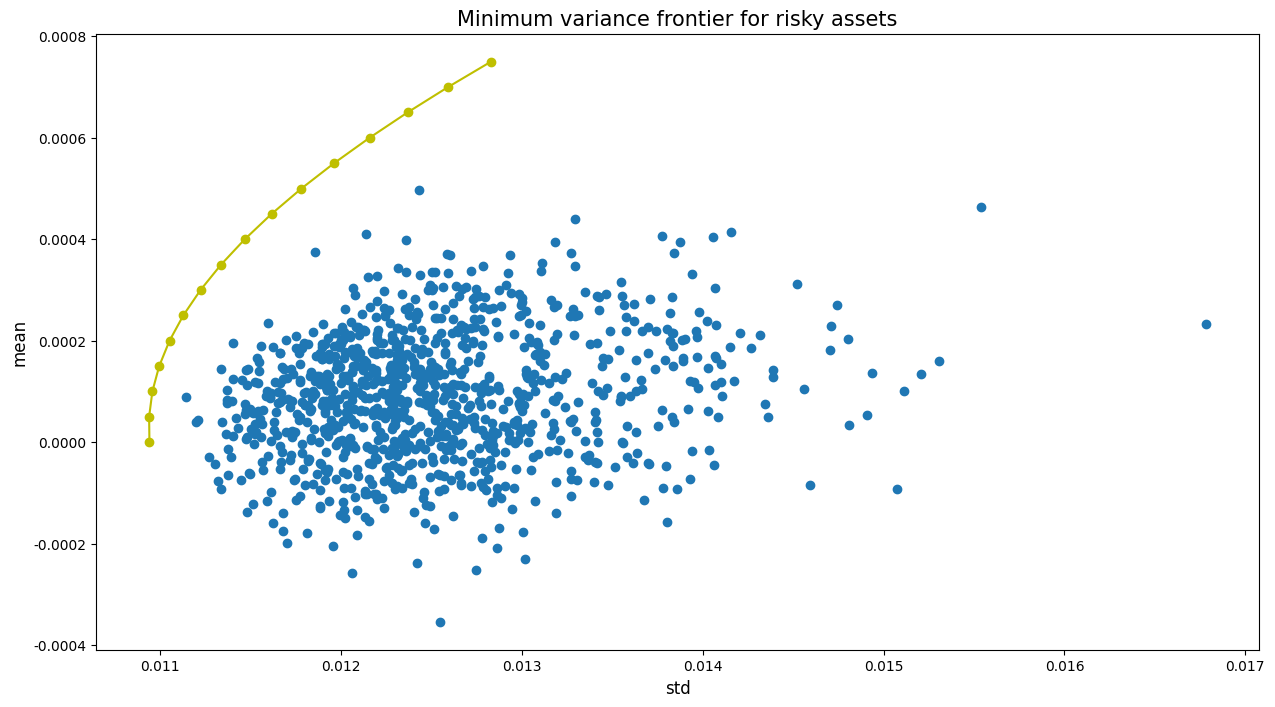

In [ ]:
#Plot minimum variance frontier (최소 분산 곡선 그래프)
#Random portfolios (무작위 포트폴리오)
means = port_ret_var['Port_ret'].values
stds = port_ret_var['Port_std'].values
 
#Minimum varaince portfolios (최소분산 포트폴리오)
opt_returns = mean_stds_df['Port_ret']
opt_stds = mean_stds_df['Port_std']
 
fig = plt.figure(figsize=(15,8))
plt.plot(stds, means, 'o')
plt.ylabel('mean',fontsize=12)
plt.xlabel('std',fontsize=12)
plt.plot(opt_stds, opt_returns, 'y-o')
plt.title('Minimum variance frontier for risky assets',fontsize=15)